# Week 5

In [2]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt


import cvxpy as cp
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, GridSearchCV
from scipy.optimize import minimize
from pandas_datareader import data 

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import factor_model_lib as fm
sys.path.append("../")
import edhec_risk_kit as erk

In [5]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

# Regime Prediction with Machine Learning - Part 1

For our analysis we will use a large macroeconomic database from **FRED St. Louis** designed by **McCracken and Ng (2015)**. 
It involves **129 macroeconomic monthly time series over the period 1959-2018**. 
The data is organized into **8 categories**:
1. Output and income
2. Labor market
3. Housing
4. Consumption, orders and inventories 
5. Money and credit
6. Interest and exchange rates
7. Prices
8. Stock market. 

Detail description of the variables under each category can be 
found __[here]( https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/Appendix_Tables_Update.pdf)__.

In [6]:
bigmacro = pd.read_csv("data/Macroeconomic_Variables.csv")
bigmacro = bigmacro.rename(columns={'sasdate':'Date'})
bigmacro = bigmacro.set_index(keys="Date")
bigmacro.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
Date,,,,,,,,,,,,,,,,,,,,,
1/1/59,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6248,23.4555,22.1893,32.4027,21.9673,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
2/1/59,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0679,23.7720,22.3816,32.6404,22.0826,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
3/1/59,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4002,23.9159,22.4914,32.6404,22.5150,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
4/1/59,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8987,24.2613,22.8210,33.1553,22.6592,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
5/1/59,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2587,24.4628,23.0407,33.3137,23.1204,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


In [7]:
# manually put the dates in datetime format. Note that directly using pd.to_datetime does not work fine 
# because up to 1968 (/68 in the index) year are parsed as years of the 21st century, i.g., 1/1/59 -> 2059-01.
years  = np.arange(1959,2019+1,1)
months = np.arange(1,12+1,1)
strdate = []
for y in years:
    for m in months:
        strdate.append( str(y) + "-" + str(m)  )
        if y==2019 and m==1:
            break
# now parse dates
bigmacro.index = pd.to_datetime(strdate, format="%Y-%m", infer_datetime_format=True).to_period("M") 
bigmacro.index.rename("Date", inplace=True)
bigmacro.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
Date,,,,,,,,,,,,,,,,,,,,,
1959-01,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6248,23.4555,22.1893,32.4027,21.9673,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
1959-02,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0679,23.7720,22.3816,32.6404,22.0826,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
1959-03,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4002,23.9159,22.4914,32.6404,22.5150,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
1959-04,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8987,24.2613,22.8210,33.1553,22.6592,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
1959-05,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2587,24.4628,23.0407,33.3137,23.1204,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


In [8]:
bigmacro.shape

(721, 128)

Consistent with the previous works in the literature, we use __[business cycle dating chronology provided by NBER](http://www.nber.org/cycles.html)__  which involves dates when recession began and ended in US economy. According to NBER's statistics we have **8 recession periods in our dataset** where duration is changing from 6 to 18 months. 

We represent regimes as **Normal and Recession** in our dataset. 

In [10]:
# load regimes classifications
recession_periods = pd.read_csv('data/Recession_Periods.csv')["Regime"]
# and insert them into bigmacro dataframe
bigmacro.insert(loc=0, column="Regime", value=recession_periods.values)
bigmacro.head()

,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
Date,,,,,,,,,,,,,,,,,,,,,
1959-01,Normal,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6248,23.4555,22.1893,32.4027,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
1959-02,Normal,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0679,23.7720,22.3816,32.6404,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
1959-03,Normal,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4002,23.9159,22.4914,32.6404,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
1959-04,Normal,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8987,24.2613,22.8210,33.1553,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
1959-05,Normal,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2587,24.4628,23.0407,33.3137,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


In [11]:
bigmacro["Regime"].value_counts()

Normal       628
Recession     93
Name: Regime, dtype: int64

We have a total of $628$ months of normal regimes and $93$ months of recession.

In [12]:
# dates of normal and recession regimes
normal_dates     = bigmacro[bigmacro["Regime"] == "Normal"].index
recessions_dates = bigmacro[bigmacro["Regime"] == "Recession"].index

In [14]:
# find indices of recession regimes 
rec_idx = np.zeros_like(recessions_dates)
rec_idx[0] = 1
for i, date in enumerate(recessions_dates):
    prev_date = date - 1
    if prev_date not in recessions_dates:
        rec_idx[i] = 1
        rec_idx[i-1] = 1
rec_idx = np.array([False if i==0 else True for i in rec_idx])

In [15]:
recessions_dates[rec_idx]

PeriodIndex(['1960-04', '1961-01', '1969-12', '1970-10', '1973-11', '1975-02',
             '1980-01', '1980-06', '1981-07', '1982-10', '1990-07', '1991-02',
             '2001-03', '2001-10', '2007-12', '2009-05'],
            dtype='period[M]', name='Date', freq='M')

#### Example using S&P500 regimes

In [16]:
# loading the S&P500 index for the current set of dates that we have 
startdate = dt.datetime(1959,1,1)
enddate = dt.datetime(2019,1,1,) 
ticker = "^GSPC"

sp500 = data.DataReader(ticker, data_source="yahoo", start=startdate, end=enddate)
sp500.insert(loc=0, column="idx", value=np.arange(0,sp500.shape[0]))
sp500 = sp500[["idx","Adj Close"]]
sp500.head()

,idx,Adj Close
Date,,
1959-01-02,0,55.439999
1959-01-05,1,55.660000
1959-01-06,2,55.590000
1959-01-07,3,54.889999
1959-01-08,4,55.400002


In [17]:
# S&P500 are daily data, then we have to find the right recession dates 
rr = []
for date in recessions_dates[rec_idx]:
    rr.append( sp500[str(date)].iloc[0,:]["idx"] ) 
rr = np.array(rr)
rr

array([  316.,   505.,  2720.,  2932.,  3711.,  4027.,  5268.,  5373.,
        5646.,  5963.,  7922.,  8071., 10616., 10760., 12314., 12669.])

In [18]:
# index of starting recession periods
x1 = np.array(rr)[:-1:2]
# index of ending recession periods
x2 = np.array(rr)[1::2]

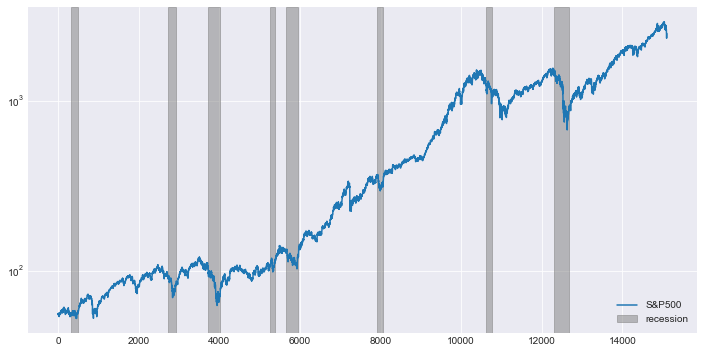

In [21]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.semilogy(sp500["Adj Close"].values, label="S&P500")

ax.axvspan(x1[0], x2[0], alpha=0.5, color='gray', label="recession")
for i in range(1,len(x1)):
    ax.axvspan(x1[i], x2[i], alpha=0.5, color='gray')
    
ax.legend()
ax.grid()
plt.show()